In [6]:
rm(list = ls())
data = read.csv("historical_data/dart.csv", header = TRUE, as.is=TRUE)


In [3]:
head(data)

timestamp,level,tot_rate,new
2008-01-01 00:00:00,0.456,0,0.0
2008-01-01 00:15:00,0.458,NA,0.0
2008-01-01 00:30:00,0.461,0,0.2
2008-01-01 00:45:00,0.466,NA,0.0
2008-01-01 01:00:00,0.472,0,0.0
2008-01-01 01:15:00,0.477,NA,0.0


In [9]:
df = data[which((data$timestamp < '2016-01-01 00:00:00') & (data$timestamp > '2015-01-01 00:00:00')),]
df$timestamp = as.POSIXct(df$timestamp)
row.names(df)= NULL
df$predict = 0


t = 0



k <- 0.07  # decribes the storage time of water within the catchment (the flashiness of the catchment). Where a value of 1 means that all water in the catchment 
# reaches the river immediately and 0 means that no water reaches the river.

scale_m = 1.943
scale_a = 0.263

S <- 0      # intial rainwater storage in catchment

delay = 4 # delay in multiples of 15 minutes
ntimesteps=nrow(df) # model runs for a year

df$storage = 0
timestep = 1



f <- function(x){
    return(exp(k*x))
}

g <- function(x){
    return((scale_m * x) + scale_a)
}

f_inv <- function(x){
    return(log(x)/k)
}

g_inv <- function(x){
    return ((x - scale_a) / scale_m)
}

In [10]:
ptm <- proc.time()

for(n in 5:nrow(df)){ # set loop to run model for each time step
    if(as.numeric(format(df$timestamp[n], "%H")) + as.numeric(format(df$timestamp[n], "%M"))/60 == 4){
        S = f_inv(g_inv(df$level[n]))
    } else {
        S <- S + df$new[n-delay] - f(S) 
    }  
    
    df$storage[n] = S
    t=t+1
}  
proc.time() - ptm


   user  system elapsed 
 14.416   0.092  14.528 

In [15]:
df$predict =  g(f(df$storage))

In [16]:
lm = lm(df$level ~ df$predict)

#df$predict_scaled = df$predict * 1.91 + 0.339
#lm = lm(df$level ~ df$predict_scaled)
summary(lm)



Call:
lm(formula = df$level ~ df$predict)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.18352 -0.03487 -0.03135  0.00813  0.70653 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.036601   0.001259   29.07   <2e-16 ***
df$predict  0.992009   0.002631  377.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1034 on 35037 degrees of freedom
Multiple R-squared:  0.8023,	Adjusted R-squared:  0.8023 
F-statistic: 1.422e+05 on 1 and 35037 DF,  p-value: < 2.2e-16


In [18]:

my_plot <- function(n, m){
  plot(df$timestamp[n:m], df$predict[n:m], ylim = c(0, 2), type="l", axes= FALSE, xlab = NULL, col = "red")
  axis(2)
  par(new=T)
  plot(df$timestamp[n:m], df$new[n:m], type="l", axes= FALSE, xlab = NULL)
  par(new=T)
  plot(df$timestamp[n:m], df$level[n:m], ylim = c(0, 2), type="l", col="blue", axes = FALSE, xlab=NULL)
  axis(4)
  axis.POSIXct(1, at = seq(df$timestamp[n], df$timestamp[m], by = "hour"), format = "%H")
}



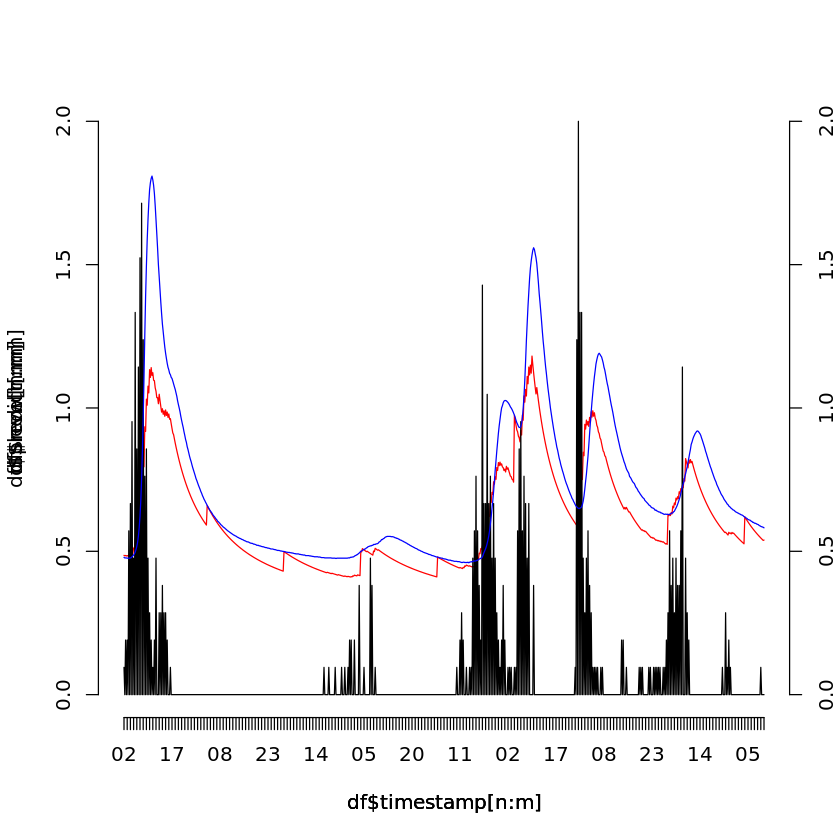

In [19]:
my_plot(200,1000)


In [11]:
min(data$level)

[1] 0.235